# Initial Imports

In [14]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, KFold
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

# Raw SA Single Observation

## Import Dataset

In [2]:
df = pd.read_csv("./../Datasets/kieranFeatures_1-30_14-Nov-2024_rawSA.csv")

## Preprocessing

In [3]:
# Imput missing values
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.mean())

# Establish binary columns
df = df.assign(
    Lv_1_Lo = lambda x: (x["SA1"] < np.median(x["SA1"])),
    Lv_2_Lo = lambda x: (x["SA2"] < np.median(x["SA2"])),
    Lv_3_Lo = lambda x: (x["SA3"] < np.median(x["SA3"])),
    Tot_Lo = lambda x: (x["SAtotal"] < np.median(x["SAtotal"]))
)

# Decompose dataset
ids = df["ID"]
trial_nums = df["trialNum"]
X = df.drop(columns = ["ID", "trialNum", "SA1", "SA2", "SA3", "SAtotal", "Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"])
y = df[["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]]
y_shuffled = y.sample(frac = 1, random_state = 42).reset_index(drop = True)

# Initialize data structure for results
dataset_types = ["Actual", "Shuffled"]
levels = ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]

## Training

In [6]:
def get_model_cv_scores(X, y):
    """
        Function to get the cross-validated F1, accuracy, ROC-AUC, and models for a given SA level.
    """

    model_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy = "mean")),
        ("scaler", StandardScaler()),
        ("classifier", LogisticRegression(penalty = None, max_iter = 10000, random_state = 42))
    ])

    return cross_validate(model_pipeline, X, y, cv = KFold(n_splits = 10, shuffle = True, random_state = 42), n_jobs = -1, scoring = ["f1", "accuracy", "roc_auc"], return_estimator = True, return_indices = True)

In [7]:
data = {}

for dataset_type in ["Actual", "Shuffled"]:
    data[dataset_type] = {}

    for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
        data[dataset_type][level] = get_model_cv_scores(X, y[level] if dataset_type == "Actual" else y_shuffled[level])

## Save and Load Data

In [8]:
# Save
with open("./../Pickle Files/Baseline_Results_Raw_SA_SO.pkl", "wb") as f:
    pickle.dump(data, f)

In [9]:
# Load
with open("./../Pickle Files/Baseline_Results_Raw_SA_SO.pkl", "rb") as f:
    data = pickle.load(f)

## Performance Graphs

In [20]:
def graph_actual_vs_shuffled(data, metric, level):
    random_guessing_baselines, always_true_lines, always_false_lines = calculate_baselines(data, level, metric)

    # Create the graph
    plt.figure(figsize = (7.5, 7.5))
    plot_scores(data, metric)
    plot_baselines(random_guessing_baselines, always_true_lines, always_false_lines, metric)

    # Visual Adjustments
    plt.xticks([0, 1], ["Actual", "Shuffled"])
    plt.xlim([-0.2, 1.2])
    plt.ylim([0, 1])
    
    # Labeling
    plt.xlabel("Model Type")
    plt.ylabel(f"{metric} Score")
    plt.title(f"{metric} Test Fold Scores for {level} Models")
    plt.legend(loc = "upper right", bbox_to_anchor = [1.3, 1])
    
    plt.show()

def calculate_baselines(data, level, metric):
    # Initialize Baselines
    random_guessing_baselines = []
    always_true_lines = []
    always_false_lines = []

    # Get baselines for each fold
    test_indices = data["Actual"][level]["indices"]["test"]
    for idx in test_indices:
        y_test = y.iloc[idx]

        if metric == "f1":
            random_guessing_baselines.append(np.mean(y_test[level]) / np.mean(y_test[level] + 0.5))
            always_true_lines.append(f1_score(y_test[level], np.array([1 for _ in range(len(y_test[level]))])))
        elif metric == "accuracy":
            random_guessing_baselines.append(0.5)
            always_false_lines.append(accuracy_score(y_test[level], np.array([0 for _ in range(len(y_test[level]))])))
        elif metric == "roc_auc":
            random_guessing_baselines.append(0.5)

    return random_guessing_baselines, always_true_lines, always_false_lines

def plot_scores(data, metric):
    actual_scores = data["Actual"][level]["test_" + metric]
    shuffled_scores = data["Shuffled"][level]["test_" + metric]

    # Plot score data points
    for i, (actual_score, shuffled_score) in enumerate(zip(actual_scores, shuffled_scores)):
        plt.plot([0, 1], [actual_score, shuffled_score], marker = "o", label = f"Test Fold {i + 1}")

    # Plot boxplots
    plt.boxplot(actual_scores, vert = True, positions = [-0.1])
    plt.boxplot(shuffled_scores, vert = True, positions = [1.1])

def plot_baselines(random_guessing_baselines, always_true_lines, always_false_lines, metric):
    if metric == "f1":
        plt.axhline(y = np.mean(always_true_lines), color = "red", label = "Always True", linestyle = "--")
    elif metric == "accuracy":
        plt.axhline(y = np.mean(always_false_lines), color = "blue", label = "Always True", linestyle = "--")
    plt.axhline(y = np.mean(random_guessing_baselines), color = "black", label = "Baseline", linestyle = "--")

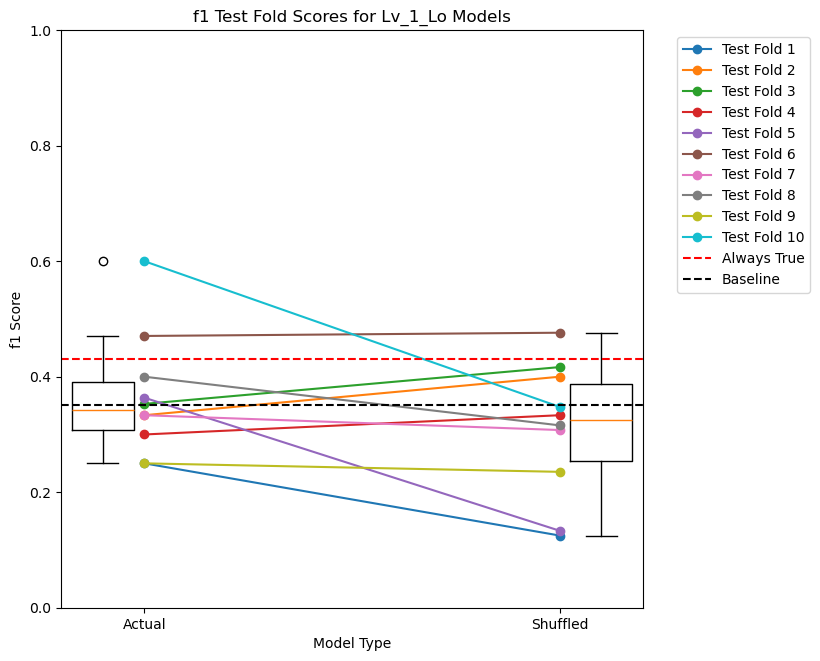

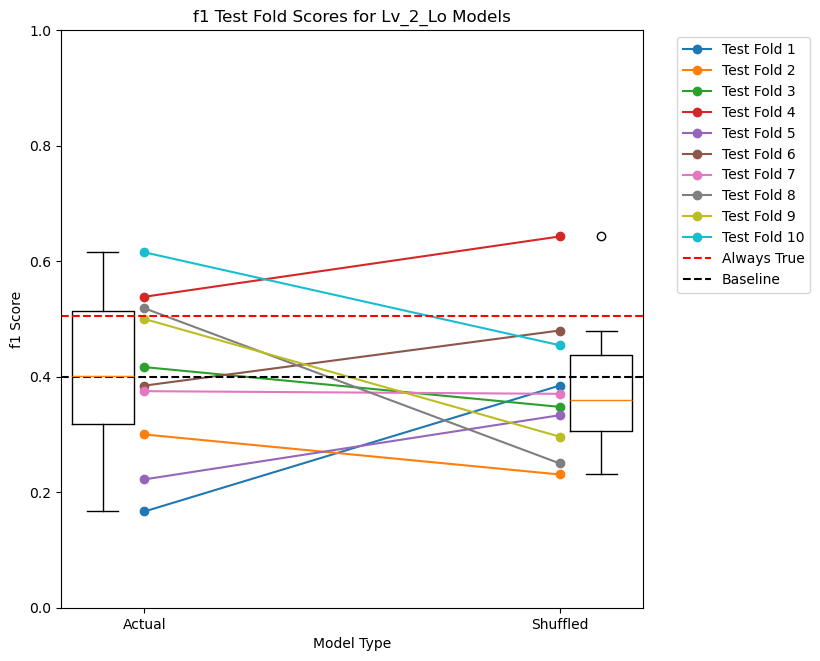

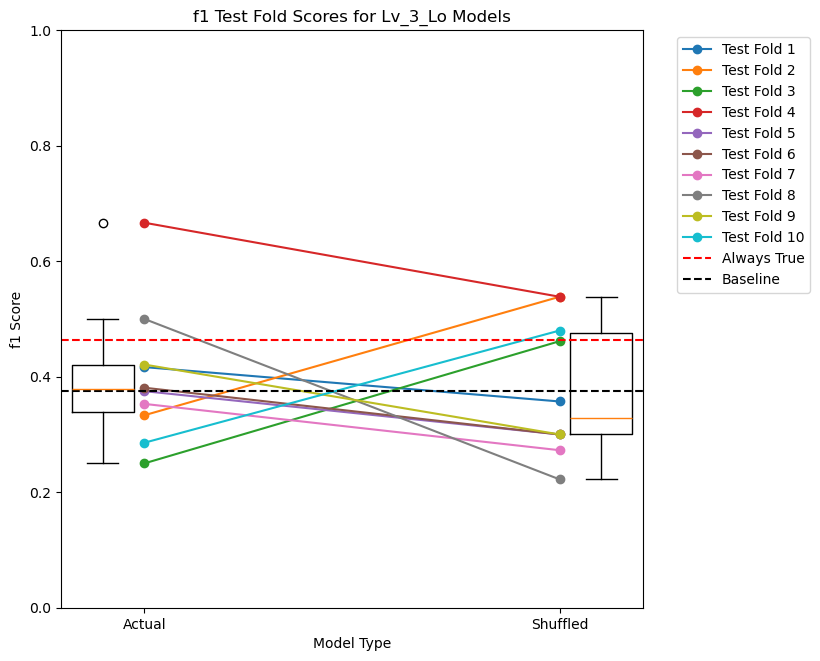

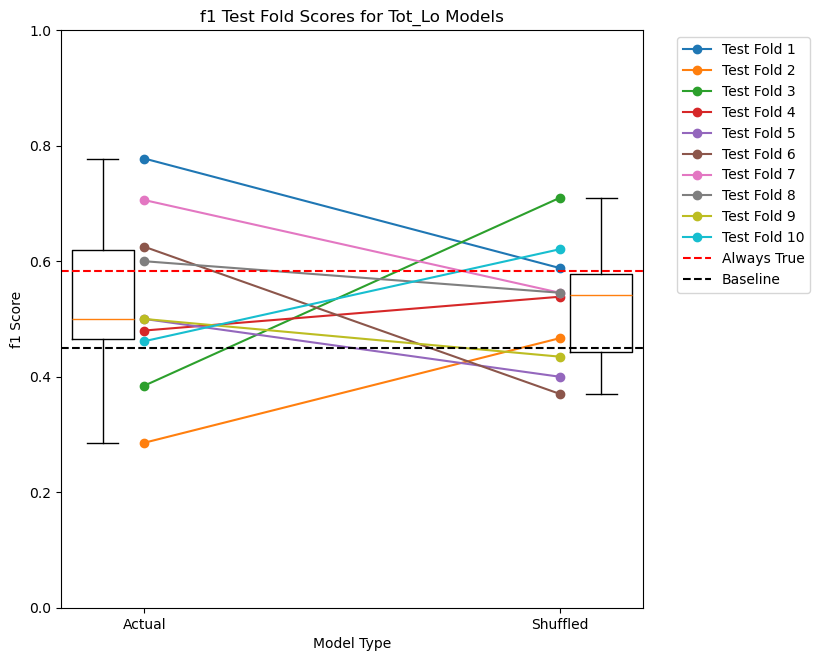

In [21]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    graph_actual_vs_shuffled(data, "f1", level)

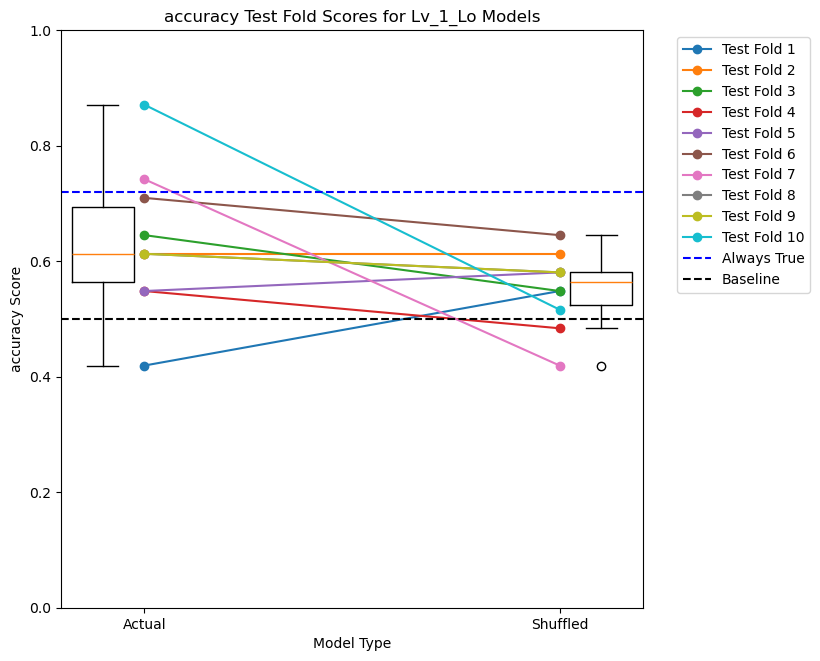

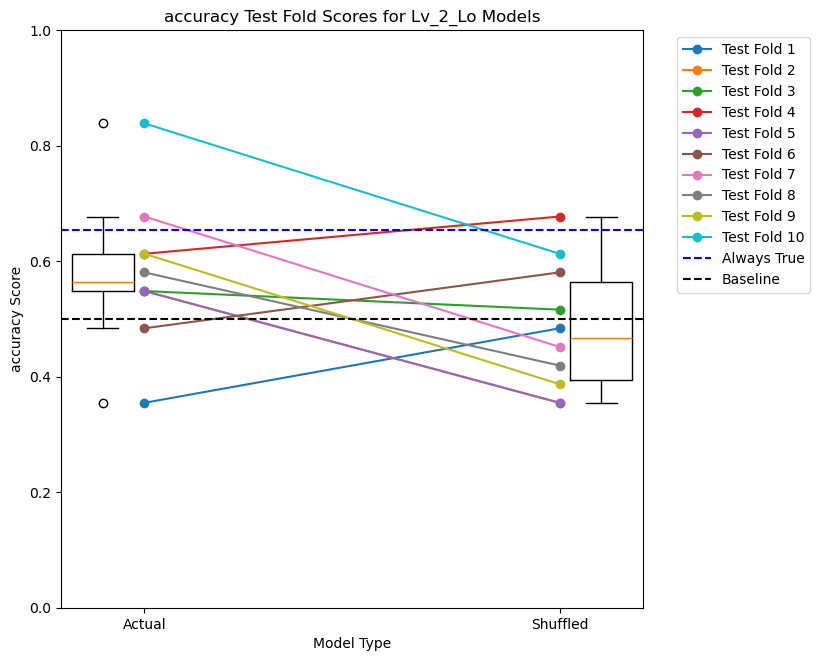

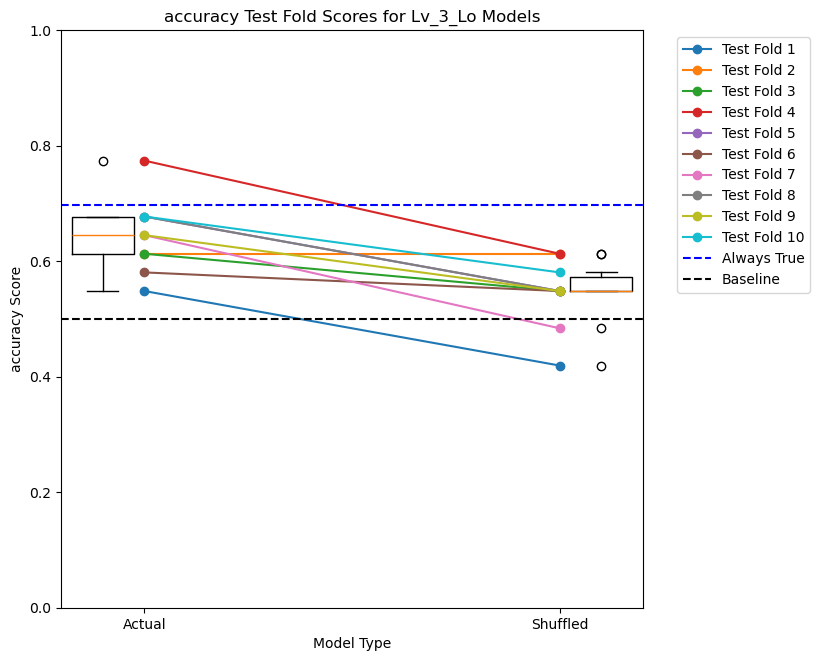

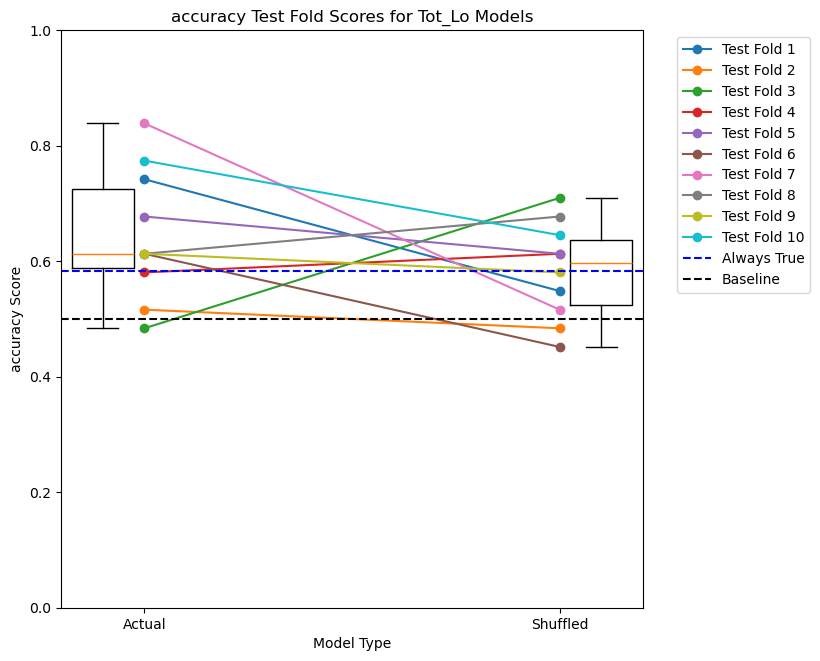

In [22]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    graph_actual_vs_shuffled(data, "accuracy", level)

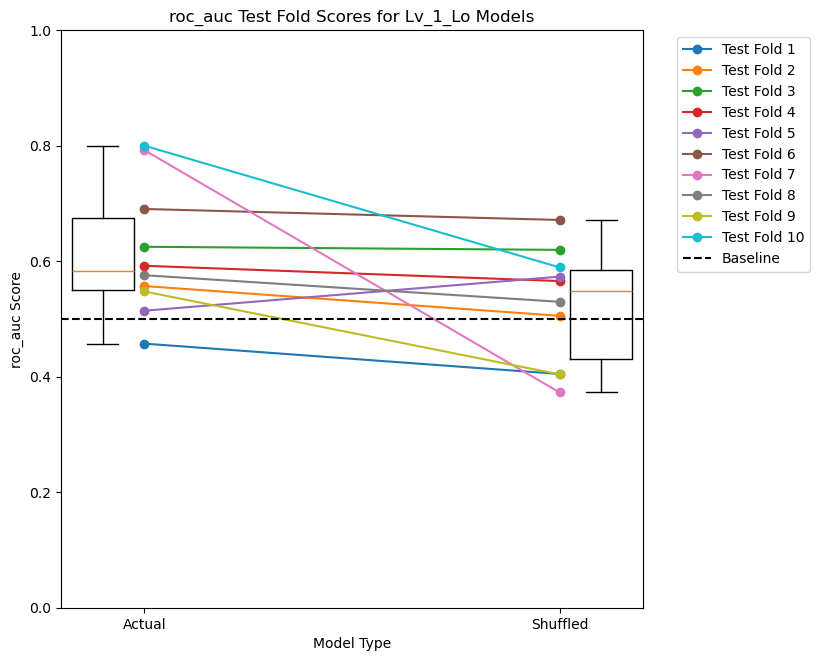

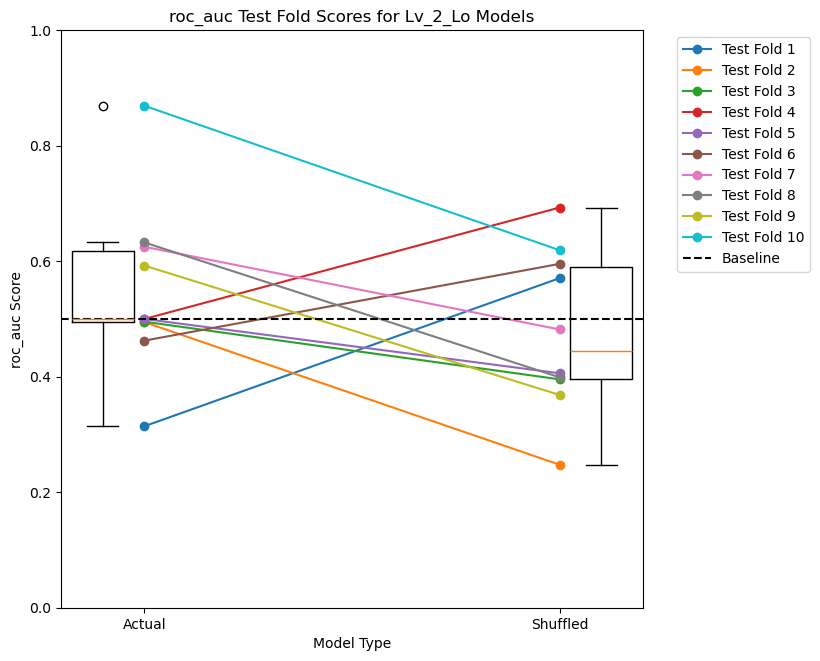

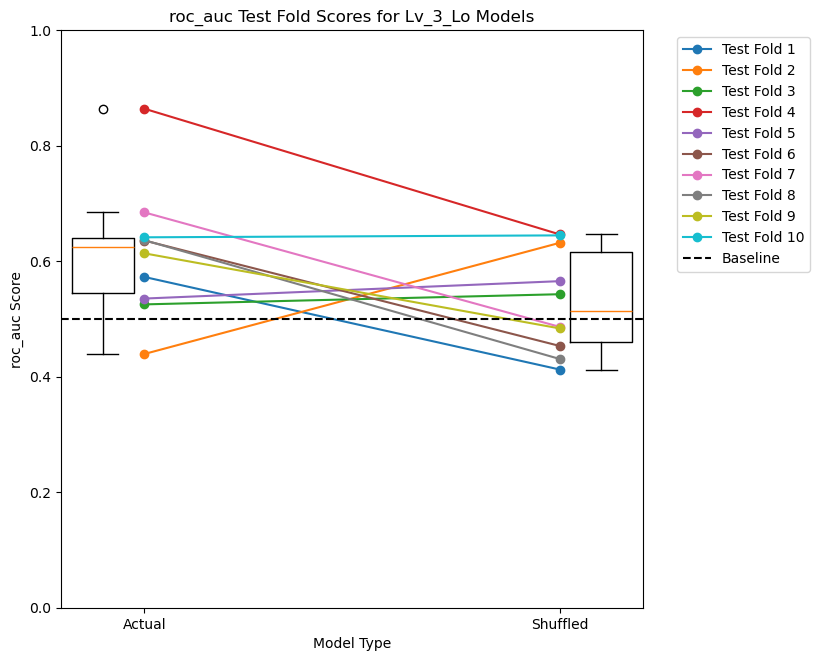

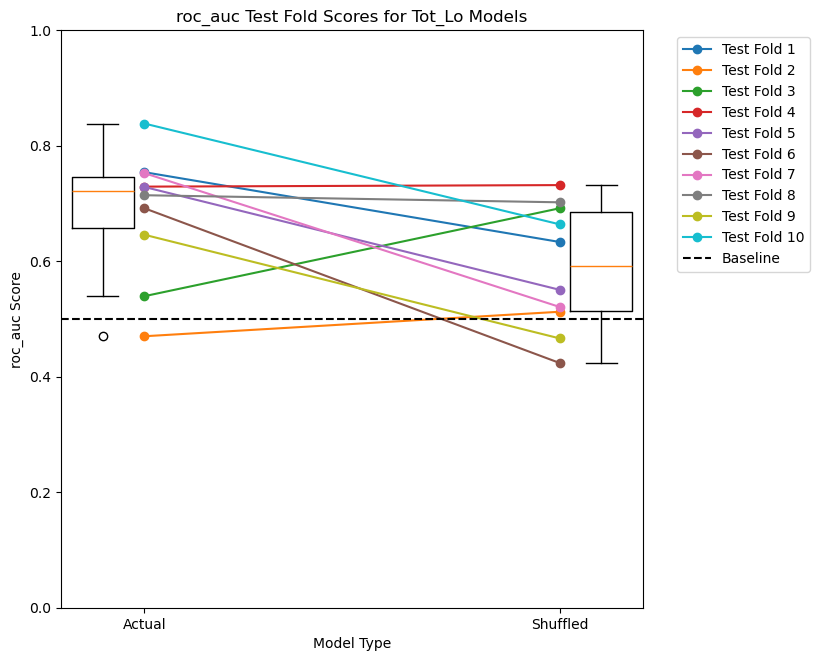

In [23]:
for level in ["Lv_1_Lo", "Lv_2_Lo", "Lv_3_Lo", "Tot_Lo"]:
    graph_actual_vs_shuffled(data, "roc_auc", level)

# Adjusted SA Single Observation

## Import Dataset

In [ ]:
# Adjusted SA Single Observation Data
df = pd.read_csv("./../Datasets/kieranFeatures_1-31_24-Jan-2025.csv")

# Raw SA Average of 3

## Import Dataset

In [ ]:
# Raw SA Average of 3
df = pd.read_csv("./../Datasets/kieranFeatures_1-31_24-Jan-2025_avgof3_rawSA.csv")

# Adjusted SA Average of 3

## Import Dataset

In [ ]:
# Adjusted SA Average of 3
df = pd.read_csv("./../Datasets/kieranFeatures_1-31_24-Jan-2025_avgof3.csv")